## OPC PDG

# Integrantes: Sandra Niño y Johnatan Garzón

En el presente jupyter notebook se hará uso de LDA (Latent Dirichlet Allocation) para que las respuestas a la pregunta "Para ti,¿Que sí es paz?", en este caso entendidos como documentos, formen topics o categorías de palabras relacionadas  a la pregunta.

In [1]:
%matplotlib inline
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression # modelos lineales
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import cross_val_score #protocolo de evaluación
from sklearn import datasets, metrics
from sklearn import preprocessing
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#remove stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/garzuzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/garzuzo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dfEncuestaSPCC=pd.read_excel('./data/encuesta_SPCC-25ABR2018-MODIFICADA-ORTOGRAFIA.xlsx')

In [3]:
dfPazUSC=pd.read_excel('./data/marco_PAZ_USC_09ABR2019_latest_version_False_2019-MAY-09_0936-MODIFICADA-ORTOGRAFIA.xlsx')

In [4]:
dfNarrativasMayo=pd.read_excel('./data/respaldo_actualizacion_NARRATIVAS-10MAY2019-0600-MODIFICADA-ORTOGRAFIA.xlsx')

# Exploración y preparación de datos

## DfEncuestaSPCC

In [5]:
dfEncuestaSPCC.head()

,¿Cuál es el sistema operativo de su dispositivo móvil?,Nombre/s:,Apellido/s:,Sexo,Edad,¿Nació en Cali?,¿En qué departamento nació?,¿En qué municipio nació?,"De acuerdo con su cultura, pueblo o rasgos físicos usted es o se reconoce como:",¿Cuántas personas componen su hogar?,...,Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Alimentación,Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Derecho a la vivienda digna,"Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/No acoso (sexual, laboral)",Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Primera infancia,Escriba una frase corta en la que exprese su significado de la Paz:,Escriba un deseo de Paz para los demás:,Sugerencias específicas para medir ¿qué si es Paz?:,Sugerencias específicas para mejorar las capacidades de la SPCC:,Sugerencias específicas al OPC para una futura encuesta:,_index
0,Android,Gregorry,Rivera Garibello,Hombre,25,Si,NaN,NaN,Ninguno de los anteriores,4,...,0,0,0,0,"La humanización del espacio, ese siempre será ...","La búsqueda sigue su curso, un gran camino ocu...",Vamos bien!!!,"Más apoyo entre equipos, para mejorar la comun...",Que sea más corta,1
1,Android,Mauricio,Sedano,Hombre,43,No,Santander,Barrancabermeja,"Negro(a), mulato(a) y afrocolombiano(a)",2,...,0,0,0,0,Mantener las familias unidas,"Identificar lo que sí es paz, y emitir recomen...","diseñar inclusión y representatividad, procesa...",Dar cursos cortos online y certificados como E...,No combinar sectores con tipos de experiencias...,2
2,Android,Andrés Felipe,Suárez Sánchez,Hombre,31,Si,NaN,NaN,Ninguno de los anteriores,2,...,0,0,0,0,La paz es satisfacer los derechos básicos cons...,Trabajemos junto en asegurar los derechos bási...,Incluir una muestra de todos los grupos social...,Promover la auto formación virtual para ser es...,Planear un poco mejor el proceso de realizació...,3
3,Android,Ana María,Gálvez Yepes,Mujer,27,Si,NaN,NaN,Ninguno de los anteriores,4,...,0,0,0,0,La paz es el bien común,"Deseo que tus días estén llenos de fuerza, fel...",Tener en cuenta la voz de las comunidades,Crear una herramieta de impacto que permita po...,Sintetizar la introducción,4
4,iOS (Iphone),Ana Cristina,Alzate Restrepo,Mujer,39,No,Antioquia,Medellín,Ninguno de los anteriores,1,...,0,0,0,0,Concertación,Tolerancia con el otro en todo momento y lugar,Conocer por medio de casos puntuales el nivel ...,Formación en proyectos sociales: formulacion y...,Medir temas de clima organizacional como una a...,5


In [6]:
dfEncuestaSPCC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Columns: 221 entries, ¿Cuál es el sistema operativo de su dispositivo móvil? to _index
dtypes: float64(64), int64(58), object(99)
memory usage: 221.1+ KB


In [7]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['¿Cuál es el sistema operativo de su dispositivo móvil?',
 'Nombre/s:',
 'Apellido/s:',
 'Sexo',
 'Edad',
 '¿Nació en Cali?',
 '¿En qué departamento nació?',
 '¿En qué municipio nació?',
 'De acuerdo con su cultura, pueblo o rasgos físicos usted es o se reconoce como:',
 '¿Cuántas personas componen su hogar?',
 'Actualmente las condiciones de vida en su hogar son:',
 'En relación al hogar donde se crió en su primera infancia, su hogar actual vive económicamente:',
 'Usted piensa que el nivel de vida actual de su hogar, respecto al que tenía 5 años atrás, es:',
 'Selecciona, según la estructura del organismo de la que haces parte:',
 'Seleccione el proyecto para el cual trabaja',
 'Especifique',
 '¿Cuál es su principal función en el proyecto?',
 '¿Cuál es el problema central que trata de resolver su proyecto?',
 '¿Qué metodología/s de trabajo destacaría/s del proyecto?, ¿por qué?',
 'Indique cinco (5x) palabras claves para su proyecto',
 'Advierta cinco (5x) palabras claves que NO son 

Como podemos apreciar esta encuesta fue demasiado extensa. Las columnas que nos interesan son:  'Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”', 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz' y  'Escriba una frase corta en la que exprese su significado de la Paz:'

In [8]:
dfEncuestaSPCC.columns.get_loc('Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”')

23

In [9]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 0:23], inplace = True, axis = 1) 

In [10]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Mencione tres (3x) palabras claves para la RECONCILIACIÓN',
 '¿Cuál es tu lugar de residencia?:',
 'Comuna:',
 'Barrio:',
 'Corregimiento:',
 'Vereda:',
 'Otros nombres utilizados para referirse a tu Barrio / Vereda / Zona / Sector:',
 'Departamento:',
 'Municipio:',
 'Tiempo de residencia:',
 '¿Qué tan satisfecho se siente de vivir en ese barrio o corregimiento?',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?/Atracos o robos',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido víctima usted o algún miembro del hogar dentro de su barrio o vereda?/Homicidios o asesinatos',
 'Durante los ÚLTIMOS DOCE MESES, ¿de cuáles de los siguientes hechos ha sido ví

In [11]:
dfEncuestaSPCC.columns.get_loc("Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz")

166

In [12]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 1:166], inplace = True, axis = 1) 

In [13]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Respeto',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Tolerancia',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Armonía',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Hogar',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Entorno protector',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/No discriminación',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Amor',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz/Compartir',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Pa

In [14]:
dfEncuestaSPCC.columns.get_loc("Escriba una frase corta en la que exprese su significado de la Paz:")

27

In [15]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 2:27], inplace = True, axis = 1) 

In [16]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Escriba una frase corta en la que exprese su significado de la Paz:',
 'Escriba un deseo de Paz para los demás:',
 'Sugerencias específicas para medir ¿qué si es Paz?:',
 'Sugerencias específicas para mejorar las capacidades de la SPCC:',
 'Sugerencias específicas al OPC para una futura encuesta:',
 '_index']

In [17]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 3:8], inplace = True, axis = 1) 

In [18]:
cols = dfEncuestaSPCC.columns.tolist()
cols

['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
 'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
 'Escriba una frase corta en la que exprese su significado de la Paz:']

Finalmente logramos obtener las 3 columnas que nos interesaban

## dfPazUSC

In [19]:
dfPazUSC.head()

,start,end,today,username,simserial,subscriberid,deviceid,phonenumber,equipo,punto_captura,...,municipio,cargo,facultad,programa_academico,__version__,_id,_uuid,_submission_time,_validation_status,_index
0,2019-04-09T10:45:13.267-05,2019-04-09T11:10:35.529-05,2019-04-09,datospazcali,89571015019090214468,732101527021446,351712103831066,NaN,equipo_6,bloque_5,...,NaN,funcionario_operativo,NaN,NaN,vTnXvdYjdSdY5wARMg2L5Q,25553871,11f1cd0d-ba51-4a6f-afcd-95b2e120158c,2019-04-09T17:37:52,NaN,1
1,2019-04-09T11:14:49.149-05,2019-04-09T11:29:32.972-05,2019-04-09,datospazcali,8957123401818574217,732123630899421,358126076228817,NaN,equipo_6,bloque_5,...,NaN,estudiante,NaN,NaN,vTnXvdYjdSdY5wARMg2L5Q,25553956,c8477283-ae3e-45e8-9e9f-9d65b0222aac,2019-04-09T17:38:35,NaN,2
2,2019-04-09T11:30:09.295-05,2019-04-09T11:32:31.353-05,2019-04-09,datospazcali,8957123401818574217,732123630899421,358126076228817,NaN,equipo_6,bloque_5,...,NaN,estudiante,salud,medicina,vTnXvdYjdSdY5wARMg2L5Q,25553957,d3608c8b-5dd3-46fe-851c-af07d3eb53e2,2019-04-09T17:38:36,NaN,3
3,2019-04-09T10:23:40.386-05,2019-04-09T10:34:34.074-05,2019-04-09,datospazcali,89571015021013409001,732101543311682,353779105621165,NaN,tecnico_OPC,entrada_KL_5ta,...,76306.0,estudiante,derecho,derecho,vTnXvdYjdSdY5wARMg2L5Q,25546856,29d3b696-4f20-4df5-b5ea-5c922a589d43,2019-04-09T15:35:10,NaN,4
4,2019-04-09T10:21:54.412-05,2019-04-09T10:34:35.893-05,2019-04-09,datospazcali,89571015017080727838,732101502072783,355656080709710,NaN,tecnico_OPC,entrada_KL_5ta,...,NaN,estudiante,derecho,derecho,vTnXvdYjdSdY5wARMg2L5Q,25546861,9519762f-e31c-4842-a2cb-abee7d6ecfaf,2019-04-09T15:35:13,NaN,5


In [20]:
cols = dfPazUSC.columns.tolist()
cols

['start',
 'end',
 'today',
 'username',
 'simserial',
 'subscriberid',
 'deviceid',
 'phonenumber',
 'equipo',
 'punto_captura',
 'narrativa_paz',
 'componentes',
 'componentes/tranquilidad',
 'componentes/familia_hogar',
 'componentes/vecinos_amigos',
 'componentes/convivencia',
 'componentes/narutaleza',
 'componentes/no_violencia',
 'componentes/zonas_verdes',
 'componentes/démas_personas',
 'componentes/respeto',
 'componentes/comunidad',
 'componentes/espiritualidad',
 'componentes/no_discriminación',
 'componentes/amor',
 'componentes/tradiciones_familiares',
 'componentes/libertad',
 'componentes/derechos_sociales',
 'componentes/salud',
 'componentes/educación',
 'componentes/derechos_espacio_publico',
 'componentes/perdón',
 'componentes/empleo',
 'componentes/reconocimiento',
 'componentes/reconciliación',
 'sexo',
 'edad',
 'departamento_nacimiento',
 'municipio_nacimiento',
 'zona_residencia',
 'comuna',
 'barrio',
 'corregimiento',
 'vereda',
 'otro_sector',
 'departament

La unica columna que nos interesa es: 'narrativa_paz'

In [21]:
dfPazUSC.columns.get_loc("narrativa_paz")

10

In [22]:
dfPazUSC.drop(dfPazUSC.iloc[:, 0:10], inplace = True, axis = 1) 

In [23]:
cols = dfPazUSC.columns.tolist()
cols

['narrativa_paz',
 'componentes',
 'componentes/tranquilidad',
 'componentes/familia_hogar',
 'componentes/vecinos_amigos',
 'componentes/convivencia',
 'componentes/narutaleza',
 'componentes/no_violencia',
 'componentes/zonas_verdes',
 'componentes/démas_personas',
 'componentes/respeto',
 'componentes/comunidad',
 'componentes/espiritualidad',
 'componentes/no_discriminación',
 'componentes/amor',
 'componentes/tradiciones_familiares',
 'componentes/libertad',
 'componentes/derechos_sociales',
 'componentes/salud',
 'componentes/educación',
 'componentes/derechos_espacio_publico',
 'componentes/perdón',
 'componentes/empleo',
 'componentes/reconocimiento',
 'componentes/reconciliación',
 'sexo',
 'edad',
 'departamento_nacimiento',
 'municipio_nacimiento',
 'zona_residencia',
 'comuna',
 'barrio',
 'corregimiento',
 'vereda',
 'otro_sector',
 'departamento',
 'municipio',
 'cargo',
 'facultad',
 'programa_academico',
 '__version__',
 '_id',
 '_uuid',
 '_submission_time',
 '_validati

In [24]:
len(cols)

46

In [25]:
dfPazUSC.drop(dfPazUSC.iloc[:, 1:47], inplace = True, axis = 1) 

In [26]:
cols = dfPazUSC.columns.tolist()
cols

['narrativa_paz']

Finalmente obtuvimos la columna que nos interesaba

## dfNarrativasMayo

In [27]:
dfNarrativasMayo.head()

,_orden,pre_INDEX\nentrada_KOBO,_grupo,index_MA\nsalida_KOBO,caso
0,1,1,n15FEB2017,299.0,sin_INDEX
1,2,2,n15FEB2017,33.0,sin_INDEX
2,3,3,n15FEB2017,375.0,con_INDEX
3,4,4,n15FEB2017,396.0,sin_INDEX
4,5,5,n15FEB2017,649.0,sin_INDEX


In [28]:
dfNarrativasMayo = pd.ExcelFile('./data/respaldo_actualizacion_NARRATIVAS-10MAY2019-0600-MODIFICADA-ORTOGRAFIA.xlsx')

Esta fuente de datos tiene varias hojas (Sheets), exactamente 6, por tanto debemos examinarlas una por una para extraer la información

In [29]:
dfSheet1 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n15FEB2017")

In [30]:
dfSheet1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,1,2,3,4,5,...,128,129,130,131,132,133,134,135,136,137
0,NaN,NaN,NaN,header_listo,NaN,responsable,NaN,nombre,apellido,barrio,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
1,NaN,NaN,NaN,NaN,NaN,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,n15FEB2017-59x,...,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,escenario
2,_indice_HORIZONTAL,NaN,NaN,NaN,NaN,1,2,3,4,5,...,69,70,71,72,73,74,75,76,77,78
3,NaN,NaN,NaN,NaN,NaN,Responsable:,NaN,Nombre:,Apellido:,Barrio:,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
4,_orden,_index,_grupo,_index_MA,caso,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
dfSheet1.columns.get_loc(55)

59

In [32]:
dfSheet1.drop(dfSheet1.iloc[:, 0:59], inplace = True, axis = 1) 

In [33]:
cols = dfSheet1.columns.tolist()


In [34]:
len(cols)

83

In [35]:
dfSheet1.drop(dfSheet1.iloc[:, 1:84], inplace = True, axis = 1) 

In [36]:
cols = dfSheet1.columns.tolist()
cols

[55]

In [37]:
dfSheet1.head(10)

,55
0,texto
1,n15FEB2017-59x
2,55
3,Texto
4,NaN
5,NaN
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...


In [38]:
dfSheet1.drop([0,1,2,3,4,5], inplace= True)

In [39]:
dfSheet1.head()

,55
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...
10,Para mi la Paz representa tranquilidad


In [40]:
dfSheet1.iloc[0:6]

,55
6,convivencia pacifica con los demás y amor
7,No aparece
8,No aparece cuadro de datos
9,La Paz para mi es tener claridad sobre las cos...
10,Para mi la Paz representa tranquilidad
11,la paz para mi creo que es vivir sin violencia...


In [41]:
dfSheet2 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n16FEB2017")

In [42]:
dfSheet2.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,1,2,3,4,5,...,126,127,128,129,130,131,132,133,134,135
0,NaN,NaN,NaN,NaN,NaN,responsable,nombre,apellido,edad,sexo,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
1,NaN,NaN,NaN,NaN,NaN,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,n16FEB2017-57x,...,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,quienes,escenario
2,_indice_HORIZONTAL,NaN,NaN,NaN,NaN,1,2,3,4,5,...,69,70,71,72,73,74,75,76,77,78
3,NaN,NaN,NaN,NaN,NaN,Responsable:,Nombre:,Apellido:,Edad,Sexo,...,policia,soldado,fauna,flora,niños,adolecentes,jovenes,adultos,adulto_mayor,NaN
4,_orden,_index,_grupo,_index_MA,caso,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
dfSheet2.columns.get_loc(6)

10

In [44]:
dfSheet2.drop(dfSheet2.iloc[:, 0:10], inplace = True, axis = 1) 

In [45]:
cols = dfSheet2.columns.tolist()
len(cols)

130

In [46]:
dfSheet2.drop(dfSheet2.iloc[:, 1:131], inplace = True, axis = 1) 

In [47]:
dfSheet2.head(10)

,6
0,texto
1,n16FEB2017-57x
2,6
3,Texto
4,NaN
5,Para mi paz es poder compartir con los demás y...
6,la paz es una construcción social que se gesta...
7,la paz es la ausencia de factores de generador...
8,Si aportamos nuestro grano de arena empezando ...
9,la paz es pasar rato con mi familia


In [48]:
dfSheet2.drop([0,1,2,3,4], inplace= True)

In [49]:
dfSheet2.head()

,6
5,Para mi paz es poder compartir con los demás y...
6,la paz es una construcción social que se gesta...
7,la paz es la ausencia de factores de generador...
8,Si aportamos nuestro grano de arena empezando ...
9,la paz es pasar rato con mi familia


In [50]:
dfSheet3 = pd.read_excel(dfNarrativasMayo, sheet_name="registros_ma-n01AGO2018")

In [51]:
dfSheet3.columns.get_loc(32)

36

In [52]:
dfSheet3.drop(dfSheet3.iloc[:, 0:36], inplace = True, axis = 1) 

In [53]:
cols = dfSheet3.columns.tolist()
len(cols)

165

In [54]:
dfSheet3.drop(dfSheet3.iloc[:, 1:166], inplace = True, axis = 1) 

In [55]:
dfSheet3.head(10)

,32
0,narrativa_text
1,n01AGO2018-118x
2,32
3,narrativa_text
4,NaN
5,"Para mi paz es cuidar la naturaleza, ser cons..."
6,La paz es tener principios morales y espiritua...
7,Paz es saber convivir en comunidad respetando ...
8,La paz para mi es que mi hijo y los demás niño...
9,La paz es aprender a convivir y respetar a las...


In [56]:
dfSheet3.drop([0,1,2,3,4], inplace= True)

In [57]:
dfSheet3.head()

,32
5,"Para mi paz es cuidar la naturaleza, ser cons..."
6,La paz es tener principios morales y espiritua...
7,Paz es saber convivir en comunidad respetando ...
8,La paz para mi es que mi hijo y los demás niño...
9,La paz es aprender a convivir y respetar a las...


In [58]:
dfSheet4 = pd.read_excel(dfNarrativasMayo, sheet_name="n15FEB2017-341x59x")

In [59]:
dfSheet4.columns.get_loc(55)

55

In [60]:
dfSheet4.drop(dfSheet4.iloc[:, 0:55], inplace = True, axis = 1) 

In [61]:
cols = dfSheet4.columns.tolist()
len(cols)

5

In [62]:
dfSheet4.drop(dfSheet4.iloc[:, 1:6], inplace = True, axis = 1) 

In [63]:
dfSheet4.head(10)

,55
0,texto
1,Texto
2,convivencia pacifica con los demás y amor
3,No aparece
4,No aparece cuadro de datos
5,La Paz para mi es tener claridad sobre las cos...
6,Para mi la Paz representa tranquilidad
7,la paz para mi creo que es vivir sin violencia...
8,paz es libertad es de lo que nos rodea los an...
9,Paz para mi es tener buena educación para pod...


In [64]:
dfSheet4.drop([0,1], inplace= True)

In [65]:
dfSheet4.head()

,55
2,convivencia pacifica con los demás y amor
3,No aparece
4,No aparece cuadro de datos
5,La Paz para mi es tener claridad sobre las cos...
6,Para mi la Paz representa tranquilidad


In [66]:
dfSheet5 = pd.read_excel(dfNarrativasMayo, sheet_name="n16FEB2017-345x57x")

In [67]:
dfSheet5.columns.get_loc(6)

6

In [68]:
dfSheet5.drop(dfSheet5.iloc[:, 0:6], inplace = True, axis = 1) 

In [69]:
cols = dfSheet5.columns.tolist()
len(cols)

52

In [70]:
dfSheet5.drop(dfSheet5.iloc[:, 1:53], inplace = True, axis = 1) 

In [71]:
dfSheet5.head(10)

,6
0,texto
1,Texto
2,donde hay paz no hay violencia
3,para mi la paz comienza en uno mismo es cuando...
4,Para mi paz es poder compartir con los demás y...
5,la paz es una construcción social que se gesta...
6,la paz es la ausencia de factores de generador...
7,la naturaleza por que me despeja lamente me ol...
8,Si aportamos nuestro grano de arena empezando ...
9,Es ayudar a mis hermanos en lo que mas se pued...


In [72]:
dfSheet5.drop([0,1], inplace= True)

In [73]:
dfSheet5.head()

,6
2,donde hay paz no hay violencia
3,para mi la paz comienza en uno mismo es cuando...
4,Para mi paz es poder compartir con los demás y...
5,la paz es una construcción social que se gesta...
6,la paz es la ausencia de factores de generador...


In [74]:
dfSheet6 = pd.read_excel(dfNarrativasMayo, sheet_name="n01AGO2018-483x118x")

In [75]:
dfSheet6.columns.get_loc(32)

32

In [76]:
dfSheet6.drop(dfSheet6.iloc[:, 0:32], inplace = True, axis = 1) 

In [77]:
cols = dfSheet6.columns.tolist()
len(cols)

87

In [78]:
dfSheet6.drop(dfSheet6.iloc[:, 1:87], inplace = True, axis = 1) 

In [79]:
dfSheet6.head(10)

,32
0,narrativa_text
1,narrativa_text
2,"Para mi paz es cuidar la naturaleza, ser cons..."
3,La paz es tener principios morales y espiritua...
4,Paz es saber convivir en comunidad respetando ...
5,"Para mi, paz es cuidar a la naturaleza, ser ..."
6,La paz para mi es que mi hijo y los demás niño...
7,La paz es aprender a convivir y respetar a las...
8,Es un símbolo que nosotros hemos adquirido com...
9,Paz con los vecinos del barrio y la casa para...


In [80]:
dfSheet6.drop([0,1], inplace= True)

In [81]:
dfSheet6.head()

,32
2,"Para mi paz es cuidar la naturaleza, ser cons..."
3,La paz es tener principios morales y espiritua...
4,Paz es saber convivir en comunidad respetando ...
5,"Para mi, paz es cuidar a la naturaleza, ser ..."
6,La paz para mi es que mi hijo y los demás niño...


## dfEncuestaSPCC

In [82]:
dfEncuestaSPCC.columns

Index(['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
       'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
       'Escriba una frase corta en la que exprese su significado de la Paz:'],
      dtype='object')

Vamos a proceder a unir las 3 columnas en 1 sola, concatenando lo que hay en cada una de las columnas y finalmente nos quedaremos con solo la que tiene la unión de las 3 columnas (Narrativa)

In [83]:
dfEncuestaSPCC["Narrativa"] = dfEncuestaSPCC['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”'] +" "+ dfEncuestaSPCC['Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz'] +" "+ dfEncuestaSPCC['Escriba una frase corta en la que exprese su significado de la Paz:']
dfEncuestaSPCC.columns

Index(['Mencione tres (3x) “Indicadores de CONSTRUCCIÓN DE PAZ”',
       'Seleccione las tres palabras/conceptos/expresiones más PODEROSAS para definir Paz',
       'Escriba una frase corta en la que exprese su significado de la Paz:',
       'Narrativa'],
      dtype='object')

In [84]:
dfEncuestaSPCC.drop(dfEncuestaSPCC.iloc[:, 0:3], inplace = True, axis = 1) 
dfEncuestaSPCC.head()

,Narrativa
0,"Tranquilidad, Convivencia, Casa, Educación, Co..."
1,Tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci..."
3,"Acción sin daño, integración comunitaria, resp..."
4,Procesos formativos y de multiplicación. Numer...


In [85]:
dfPazUSC.columns = ['Narrativa']
dfSheet1.columns = ['Narrativa']
dfSheet2.columns = ['Narrativa']
dfSheet3.columns = ['Narrativa']
dfSheet4.columns = ['Narrativa']
dfSheet5.columns = ['Narrativa']
dfSheet6.columns = ['Narrativa']

In [86]:
df= pd.DataFrame(columns = ['Narrativa'])

Ahora vamos a unir todos los dataframes en 1 solo bajo la columna "Narrativa"

In [87]:
df = (pd.concat([df, dfEncuestaSPCC], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfPazUSC], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet1], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet2], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet3], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet4], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet5], ignore_index=True)
        .reindex(columns=df.columns))
df = (pd.concat([df, dfSheet6], ignore_index=True)
        .reindex(columns=df.columns))

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 1 columns):
Narrativa    2969 non-null object
dtypes: object(1)
memory usage: 23.6+ KB


In [89]:
df.describe

<bound method NDFrame.describe of                                               Narrativa
0     Tranquilidad, Convivencia, Casa, Educación, Co...
1     Tiempo en horas de día de semana y de fin de s...
2     tranquilidad, familia, empleabilidad Toleranci...
3     Acción sin daño, integración comunitaria, resp...
4     Procesos formativos y de multiplicación. Numer...
...                                                 ...
2999  siento paz cuando estoy en mi casa porque sien...
3000  para mi la paz se basa en algo mas sencillo qu...
3001  la paz esta en el placer y gusto para la socie...
3002  la paz es un estado emocional,  del ser,  el c...
3003  para mi la paz es cuando no hay conflicto: pel...

[3004 rows x 1 columns]>

Luego de agrupar todas las narrativas de paz en una sola columna procedemos a la limpieza de los datos

## Datos en Null  

In [90]:
import re

In [91]:
len(df.loc[df.Narrativa.isnull()])

35

Observamos que hay filas con datos en null y procedemos a eliminarlos

In [92]:
df=df[~df.Narrativa.isnull()]

Vamos a eliminar la puntuación que puedan tener los textos

In [93]:
df['Narrativa_processed']=df['Narrativa'].map(lambda x: re.sub('[,\.\'\"!\)(?0-9]', '', str(x))) #[!@#$%^&*(),.?":{}|<>]

<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<input>:1: DeprecationWarning: invalid escape sequence \.
<ipython-input-93-e9b83de3eb00>:1: DeprecationWarning: invalid escape sequence \.
  df['Narrativa_processed']=df['Narrativa'].map(lambda x: re.sub('[,\.\'\"!\)(?0-9]', '', str(x))) #[!@#$%^&*(),.?":{}|<>]
/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
df.head(10)

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",Tranquilidad Convivencia Casa Educación Colect...
1,Tiempo en horas de día de semana y de fin de s...,Tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad Tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",Acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,Procesos formativos y de multiplicación Numero...
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...",INICIATIVAS DE CULTURA CIUDADANA EVENTOS DE CI...
6,"Comunicación, tolerancia, concertación. Tolera...",Comunicación tolerancia concertación Toleranci...
7,"Voluntad,comunicación, Reglas Respeto Toleranc...",Voluntadcomunicación Reglas Respeto Tolerancia...
8,1. Sensibilidad social respecto temáticas coti...,Sensibilidad social respecto temáticas cotidi...
9,"Cambio de percepción comunitaria, fortalecimie...",Cambio de percepción comunitaria fortalecimien...


Procederemos a poner en minuscula los textos

In [95]:
df['Narrativa_processed']=df['Narrativa_processed'].map(lambda x: x.lower().strip())

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
df.head(100)

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...
...,...,...
96,"coexistencia, rechazo a la violencia, confianz...",coexistencia rechazo a la violencia confianza ...
97,"Inclusión de grupos en conflito, Realización d...",inclusión de grupos en conflito realización de...
98,1. Iniciativas comunitarias que promueven cult...,iniciativas comunitarias que promueven cultura...
99,"goce pleno de derechos, justicia social, gober...",goce pleno de derechos justicia social goberna...


In [97]:
from wordcloud import WordCloud

In [98]:
long_string = ','.join(list(df['Narrativa_processed'].values))

In [99]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

In [100]:
wordcloud.generate(long_string)

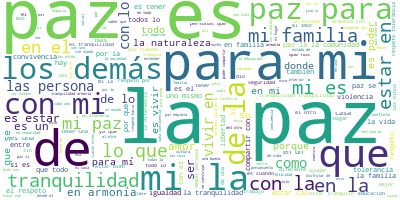

In [101]:
wordcloud.to_image()

En esta imagen podemos observar las diferentes palabras que se encuentran en los textos. Aquí podemos observar que hay stopwords como mi, la, en, con, es, los cuales no nos proporcionan información relevante y por tanto se debe eliminar.

In [102]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS


/usr/local/anaconda/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/usr/local/anaconda/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [103]:
df.head()

,Narrativa,Narrativa_processed
0,"Tranquilidad, Convivencia, Casa, Educación, Co...",tranquilidad convivencia casa educación colect...
1,Tiempo en horas de día de semana y de fin de s...,tiempo en horas de día de semana y de fin de s...
2,"tranquilidad, familia, empleabilidad Toleranci...",tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...",acción sin daño integración comunitaria respet...
4,Procesos formativos y de multiplicación. Numer...,procesos formativos y de multiplicación numero...


## Tokenización

Ahora convertiremos las oraciones en tokens (palabras). A esto se le llama Tokenización.

In [104]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc= True))  # deacc=True removes punctuations

data = df.Narrativa_processed.values.tolist()
data_tokenized = list(sent_to_words(data)) 
df["Narrativa_processed"] = list(sent_to_words(df["Narrativa_processed"]))

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [105]:
data_tokenized[0:5]

[['tranquilidad',
  'convivencia',
  'casa',
  'educacion',
  'colectividad',
  'respeto',
  'tranquilidad',
  'acceso',
  'la',
  'educacion',
  'la',
  'humanizacion',
  'del',
  'espacio',
  'ese',
  'siempre',
  'sera',
  'el',
  'camino'],
 ['tiempo',
  'en',
  'horas',
  'de',
  'dia',
  'de',
  'semana',
  'de',
  'fin',
  'de',
  'semana',
  'en',
  'el',
  'que',
  'los',
  'padres',
  'cuidadores',
  'pasan',
  'tiempo',
  'con',
  'los',
  'hijos',
  'en',
  'espacios',
  'del',
  'ie',
  'de',
  'los',
  'hijos',
  'tiempo',
  'en',
  'horas',
  'de',
  'los',
  'hijos',
  'en',
  'el',
  'que',
  'pasan',
  'tiempo',
  'con',
  'los',
  'padres',
  'mayores',
  'evidencias',
  'de',
  'mantener',
  'la',
  'familia',
  'unida',
  'hogar',
  'equilibrio',
  'hogar',
  'mantener',
  'las',
  'familias',
  'unidas'],
 ['tranquilidad',
  'familia',
  'empleabilidad',
  'tolerancia',
  'tranquilidad',
  'hogar',
  'la',
  'paz',
  'es',
  'satisfacer',
  'los',
  'derechos',
  

In [106]:
df.Narrativa_processed.head(5)

0    [tranquilidad, convivencia, casa, educacion, c...
1    [tiempo, en, horas, de, dia, de, semana, de, f...
2    [tranquilidad, familia, empleabilidad, toleran...
3    [accion, sin, dano, integracion, comunitaria, ...
4    [procesos, formativos, de, multiplicacion, num...
Name: Narrativa_processed, dtype: object

## Remover Stop words

Removemos las palabras que son conocidas como "Stop words": lo, la, con, antes, sin, de, entre otras, de los datos tokenizados. 

In [107]:
stop_words_exceptions=["no"]
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if (word not in stop_words) or (word in stop_words_exceptions)] for doc in texts]
    
    
data_tokenized_nostops= remove_stopwords(data_tokenized)


## Descubrimiento de Bigramas y Trigramas

Consiste en encontrar conjuntos de 2 (bi) o 3 (tri) palabras que formen significado.

In [108]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_tokenized, min_count=7, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_tokenized], threshold=5)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_bigrams = make_bigrams(data_tokenized)
data_bigrams_nonstops=make_bigrams(data_tokenized_nostops)

Observaremos la diferencia entre crear bigramas con y sin stopwords.

In [109]:
listBi=[]
for text in data_bigrams_nonstops:
    
    for token in text:
        if "_" in token:
           
            listBi.append(token)

mySet=set(listBi)
print(mySet)
print("tamano lista de bigramas sin stopwords:",len(listBi))
print("tamano lista de bigramas sin stopwords unicos:",len(mySet))
print("_____________________________________________________________________________________________")
listBi=[]
for text in data_bigrams:
    
    for token in text:
        if "_" in token:
           
            listBi.append(token)

mySet=set(listBi)
print(mySet)
print("tamano lista de bigramas con stopwords:",len(listBi))
print("tamano lista de bigramas con stopwords unicos:",len(mySet))

{'seres_humanos', 'libre_feliz', 'tener_buena', 'puedan_salir', 'ser_humano', 'jugar_futbol', 'ninos_jugando', 'cualquier_lugar', 'derechos_sociales', 'mas_alla', 'no_violencia', 'demas_personas', 'si_generamos', 'poder_compartir', 'aprender_convivir', 'conmigo_misma', 'buenas_personas', 'trabajo_empleo', 'buenos_valores', 'iniciativas_comunitarias', 'libre_expresion', 'paz_', 'poder_convivir', 'ser_libre', 'seres_vivos', 'migo_mismo', 'bien_conmigo', 'medio_ambiente', 'buena_relacion', 'sigo_mismo', 'respeto_hacia', 'mas_importante', 'poder_salir', 'sana_convivencia', 'seres_queridos', 'poder_respirar', 'ser_solidario', 'ninos_puedan', 'buena_convivencia', 'entorno_protector', 'conmigo_mismo', 'buenas_acciones', 'asi_mismo', 'justicia_social', 'escuchar_musica', 'ninos_ninas', 'cultura_ciudadana', 'sentirse_tranquilo', 'hacer_actividades', 'vivir_tranquilo', 'gracias_dios', 'convivencia_pacifica', 'buena_comunicacion', 'mismos_derechos', 'ser_tolerante', 'recursos_naturales', 'fronter

 Vemos que a pesar de que con stopwords se tiene una mayor cantidad de bigramas, no nos brinda una buena generalización.

Ahora, observaremos la diferencia entre crear trigramas con y sin stopwords. 

In [110]:
data_trigrams = make_trigrams(data_tokenized)
data_trigrams_nonstops=make_trigrams(data_tokenized_nostops)

listBi=[]
for text in data_trigrams_nonstops:
    
    for token in text:
        if "_" in token:
           
            listBi.append(token)

mySet=set(listBi)
print(mySet)
print("tamano lista de trigramas sin stopwords:",len(listBi))
print("tamano lista de trigramas sin stopwords unicos:",len(mySet))
print("_____________________________________________________________________________________________")
listBi=[]
for text in data_trigrams:
    
    for token in text:
        if "_" in token:
           
            listBi.append(token)

mySet=set(listBi)
print(mySet)
print("tamano lista de trigramas con stopwords:",len(listBi))
print("tamano lista de trigramas con stopwords unicos:",len(mySet))

{'libre_feliz', 'misma_comunidad', 'ser_humano', 'economica_social', 'derechos_sociales', 'mas_alla', 'ser_tolerantes', 'poder_compartir', 'buenas_personas', 'union_familiar', 'ser_libre', 'migo_mismo', 'respeto_hacia', 'sana_convivencia', 'entorno_protector', 'podamos_convivir', 'asi_mismo', 'tolerancia_respeto', 'vida_espiritual', 'poder_hacer', 'cultura_ciudadana', 'gracias_dios', 'no_pelear', 'poder_disfrutar', 'estan_peleando', 'recursos_naturales', 'respeto_tolerancia', 'hacen_parte', 'personas_puedan', 'cada_persona', 'siempre_pensando', 'demas_personas', 'conmigo_misma', 'paz_', 'familia_compartir', 'sigo_mismo', 'mas_importante', 'no_discriminacion_derechos_sociales', 'ninos_ninas', 'derechos_fundamentales', 'ala_vida', 'servir_ala', 'cada_vez', 'fronteras_pasar', 'derechos_humanos', 'dia_dia', 'no_discriminacion', 'no_haber', 'puedan_salir', 'ninos_jugando', 'no_violencia_derechos_sociales', 'no_violencia', 'seres_vivos', 'bien_conmigo', 'conceptos_opiniones', 'buena_relacion

Vemos que a pesar de que con stopwords se tiene una mayor cantidad de trigramas, no nos brinda una buena generalización. - Este resultado muestra que se hace una mejor relación de palabras con los bigramas que con los trigramas generando mejores significados de palabras, además de las 1385 palabras que se encontraron en los trigramas, realmente 4 son trigramas, y estos no poseen mucho significado:
1. no_discriminacion_derechos_sociales
2. no_violencia_derechos_sociales
3. no_discriminacion_no_violencia
4. tener_buena_convivencia

In [111]:
df['Narrativa_bigrams'] = data_bigrams_nonstops

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
df.Narrativa_bigrams

0       [tranquilidad, convivencia, casa, educacion, c...
1       [tiempo, horas, dia, semana, fin, semana, padr...
2       [tranquilidad, familia, empleabilidad, toleran...
3       [accion, dano, integracion, comunitaria, respe...
4       [procesos, formativos, multiplicacion, numero,...
                              ...                        
2999    [siento, paz, casa, siento, no, corro, ningun,...
3000    [paz, basa, mas, sencillo, prohibir, guerras, ...
3001    [paz, placer, gusto, sociedad, contando, derec...
3002    [paz, emocional, ser, genera, tranquilidad, pe...
3003             [paz, no, conflicto, pelea, discusiones]
Name: Narrativa_bigrams, Length: 2969, dtype: object

## Lematización

Procederemos a realizar la lematización. Esto consiste en convertir las palabras de la siguiente manera: si hay verbos en pasado o futuro los convierte a presente, si hay palabras en tercera persona las convierte a primera persona. 

Podriamos en este paso realizar el proceso de Stemming (convertir la palabra a su root word). Sin embargo, decidimos no implementarlo puesto que convierte las palabras hasta un punto que no nos genera valor, por ejemplo, "Computador" lo convertiría a "Comput" lo cual no es significativo para nuestro objetivo del proyecto. Por tanto, solo nos quedamos con el proceso de lematización. 

La lematización es similar al stemming, pero el primero brinda contexto a las palabras. 


- Primero pasamos los tokens a una línea de texto

In [113]:
data = df["Narrativa_bigrams"].values.tolist()

print(data[0:5])
data_prepared=[]
for row in data:
    text=""
    for word in row:
        if(len(word) > 3):
            text+=word + " "
    data_prepared.append(text.rstrip())

print("Arreglado")
print(data_prepared[0:10])

[['tranquilidad', 'convivencia', 'casa', 'educacion', 'colectividad', 'respeto', 'tranquilidad', 'acceso', 'educacion', 'humanizacion', 'espacio', 'siempre', 'sera', 'camino'], ['tiempo', 'horas', 'dia', 'semana', 'fin', 'semana', 'padres', 'cuidadores', 'pasan', 'tiempo', 'hijos', 'espacios', 'ie', 'hijos', 'tiempo', 'horas', 'hijos', 'pasan', 'tiempo', 'padres', 'mayores', 'evidencias', 'mantener', 'familia', 'unida', 'hogar', 'equilibrio', 'hogar', 'mantener', 'familias', 'unidas'], ['tranquilidad', 'familia', 'empleabilidad', 'tolerancia', 'tranquilidad', 'hogar', 'paz', 'satisfacer', 'derechos', 'basicos', 'vivienda', 'alimentacion', 'salud', 'educacion'], ['accion', 'dano', 'integracion', 'comunitaria', 'respeto', 'derechos_humanos', 'hogar', 'compartir', 'tranquilidad', 'paz', 'bien', 'comun'], ['procesos', 'formativos', 'multiplicacion', 'numero', 'alianzas', 'publico', 'privadas', 'numero', 'acciones', 'proteccion', 'ddhh', 'tolerancia', 'no_violencia', 'derechos_sociales', 'c

Ingresamos cada linea de texto en la fila correspondiente

In [114]:
df["Narrativa_bigrams"]=pd.DataFrame(data=data_prepared,columns=["Narrativa_bigrams"]).values

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [115]:
df.head()

,Narrativa,Narrativa_processed,Narrativa_bigrams
0,"Tranquilidad, Convivencia, Casa, Educación, Co...","[tranquilidad, convivencia, casa, educacion, c...",tranquilidad convivencia casa educacion colect...
1,Tiempo en horas de día de semana y de fin de s...,"[tiempo, en, horas, de, dia, de, semana, de, f...",tiempo horas semana semana padres cuidadores p...
2,"tranquilidad, familia, empleabilidad Toleranci...","[tranquilidad, familia, empleabilidad, toleran...",tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...","[accion, sin, dano, integracion, comunitaria, ...",accion dano integracion comunitaria respeto de...
4,Procesos formativos y de multiplicación. Numer...,"[procesos, formativos, de, multiplicacion, num...",procesos formativos multiplicacion numero alia...


Procedemos a realizar la lematización.
Primero cargamos la librería de spacy en español

In [116]:
import spacy
nlp = spacy.load('es_core_news_sm')

Solo realizaremos la lematización sobre:
- Adjetivos
- Verbos
- Adverbios

No lo realizaremos sobre sustantivos puesto que, después de pruebas, las palabras pierden su significado original, por ejemplo: hermano lo convierte a hermanar, casa lo convierte a casar. Esto es un defecto de la librería. 

In [117]:
allowed_postags=['ADJ', 'VERB', 'ADV']
stopwordsToken=["demas","tener","mismo", "poder","cada","tambien", "hacer"]
unifiedWord={"respetar":"respeto", "violencia":"no_violencia","musicar":"musica","guerra":"no_guerra"}
data_list=[]

for row in df.Narrativa_bigrams:
    token_list=""
    text=nlp(row)
    for token in text:
        if (token.pos_ in allowed_postags) and (token.lemma_ not in stopwordsToken) and (token.text not in stopwordsToken):
            if token.lemma_ in unifiedWord:
                token_list+=unifiedWord[token.lemma_]+" "
            else :
                token_list+=token.lemma_+" "
            
        elif (token.is_stop is not True) and (token.lemma_ not in stopwordsToken) and (token.text not in stopwordsToken):
            if token.text in unifiedWord:
                token_list+=unifiedWord[token.text]+" "
            else :
                token_list+=token.text+" "
    data_list.append(token_list.rstrip())

Ahora el resultado de la lematización lo pasamos a un nuevo dataframe

In [119]:
df_lemmatized=pd.DataFrame(data=data_list,columns=["Narrativa_bigrams"])

In [120]:
df_lemmatized.head()

,Narrativa_bigrams
0,tranquilidad convivencia casa educacion colect...
1,semana semana padres cuidadores pasar hijos es...
2,tranquilidad familia empleabilidad tolerancia ...
3,accion dano integracion comunitaria respeto de...
4,procesos formativo multiplicacion numero alian...


La lista de textos lematizados ahora se pasan a una nueva columna del dataframe llamada Narrativa_lemmatized

In [121]:
df["Narrativa_lemmatized"]= df_lemmatized.values

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Observamos la diferencia en la limpieza de los datos en cada columna. 

In [122]:
df.head(50)

,Narrativa,Narrativa_processed,Narrativa_bigrams,Narrativa_lemmatized
0,"Tranquilidad, Convivencia, Casa, Educación, Co...","[tranquilidad, convivencia, casa, educacion, c...",tranquilidad convivencia casa educacion colect...,tranquilidad convivencia casa educacion colect...
1,Tiempo en horas de día de semana y de fin de s...,"[tiempo, en, horas, de, dia, de, semana, de, f...",tiempo horas semana semana padres cuidadores p...,semana semana padres cuidadores pasar hijos es...
2,"tranquilidad, familia, empleabilidad Toleranci...","[tranquilidad, familia, empleabilidad, toleran...",tranquilidad familia empleabilidad tolerancia ...,tranquilidad familia empleabilidad tolerancia ...
3,"Acción sin daño, integración comunitaria, resp...","[accion, sin, dano, integracion, comunitaria, ...",accion dano integracion comunitaria respeto de...,accion dano integracion comunitaria respeto de...
4,Procesos formativos y de multiplicación. Numer...,"[procesos, formativos, de, multiplicacion, num...",procesos formativos multiplicacion numero alia...,procesos formativo multiplicacion numero alian...
5,"INICIATIVAS DE CULTURA CIUDADANA, EVENTOS DE C...","[iniciativas, de, cultura, ciudadana, eventos,...",iniciativas cultura_ciudadana eventos ciudad p...,iniciativas cultura_ciudadana eventos ciudad p...
6,"Comunicación, tolerancia, concertación. Tolera...","[comunicacion, tolerancia, concertacion, toler...",comunicacion tolerancia concertacion toleranci...,comunicacion tolerancia concertacion toleranci...
7,"Voluntad,comunicación, Reglas Respeto Toleranc...","[reglas, respeto, tolerancia, hogar, estado, d...",reglas respeto_tolerancia hogar tranquilidad c...,reglas respeto_tolerancia hogar tranquilidad c...
8,1. Sensibilidad social respecto temáticas coti...,"[sensibilidad, social, respecto, tematicas, co...",sensibilidad social respecto tematicas cotidia...,sensibilidad social tematicas cotidiano apropi...
9,"Cambio de percepción comunitaria, fortalecimie...","[cambio, de, percepcion, comunitaria, fortalec...",cambio percepcion comunitaria fortalecimiento ...,cambio percepcion comunitaria fortalecimiento ...


Ahora visualizaremos una nube de palabras que contiene las palabras más significativas después de haber realizado la limpieza de los datos.

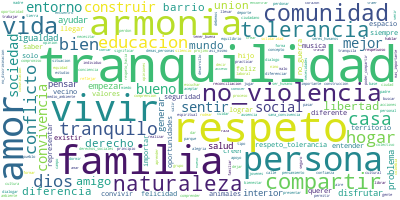

In [123]:
# Join the different processed titles together.
long_string = ' '.join(list(df['Narrativa_lemmatized'].values))

#stopwordsWc=["demas","tener","mismo","poder","cada","tambien", "hacer"]
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", collocations=False,  max_words=5000, contour_width=3, contour_color='steelblue')#,stopwords=stopwordsWc)
# Generate a word cloud
wordcloud.generate(long_string )
# Visualize the word cloud
wordcloud.to_image()

In [128]:
print("número total de narrativas (textos realizados por cada persona):", df.shape[0])

número total de narrativas (textos realizados por cada persona): 2969


In [129]:
print("número total de palabras:", len(long_string.split(" ")))

número total de palabras: 22714


Ahora guardamos la nube de palabras en una imagen en el directorio actual

In [126]:
wordcloud.to_file("./peaceWordCloud.png")

Guardamos los datos para ser procesados en el modelo

In [127]:
ruta = './data/'
nombre_base = 'df_limpieza'

nombre_archivo = ruta + nombre_base+'.xlsx'

writer = pd.ExcelWriter(nombre_archivo)
df.Narrativa_lemmatized.to_excel(writer,index=False)
writer.save()